<a href="https://colab.research.google.com/github/soultanyousif/Emotion-Classification/blob/main/Emotion_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
emotions_df=pd.read_csv('/content/emotions (1).csv')
emotions_df.shape

(2132, 2549)

In [ ]:
emotions_df['label'].unique()

array(['NEGATIVE', 'NEUTRAL', 'POSITIVE'], dtype=object)

In [ ]:
emotions_df.isnull().sum().sort_values(ascending=False)

,0
label,0
# mean_0_a,0
mean_1_a,0
mean_2_a,0
mean_3_a,0
...,...
mean_d_4_a,0
mean_d_3_a,0
mean_d_2_a,0
mean_d_1_a,0


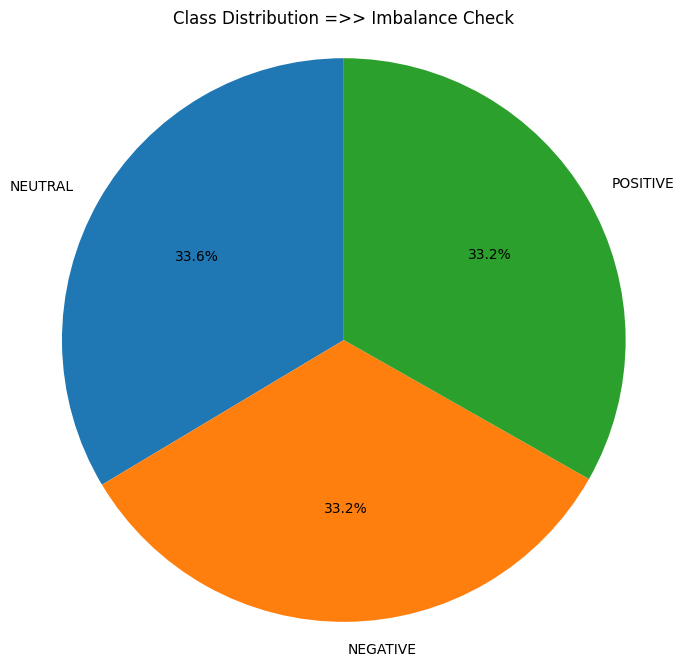

In [ ]:
import matplotlib.pyplot as plt
label_counts = emotions_df['label'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution =>> Imbalance Check')
plt.axis('equal')
plt.show()



In [ ]:
emotions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2548), object(1)
memory usage: 41.5+ MB


In [ ]:
le = LabelEncoder()
scaler = StandardScaler()


In [ ]:
def preprocessing(df, timesteps=32):

    X = df.drop(columns=['label'])
    y = df['label']

    X_scaled = scaler.fit_transform(X)
    y_encoded = le.fit_transform(y)
    y_categorical = to_categorical(y_encoded, num_classes=3)

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_scaled, y_categorical, test_size=0.30, random_state=42, stratify=y_encoded
    )

    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, random_state=42
    )

    #features per timestep
    n_features_total = X_train.shape[1]
    features_per_timestep = n_features_total // timesteps

    n_features_used = timesteps * features_per_timestep

    X_train_reshaped = X_train[:, :n_features_used].reshape((X_train.shape[0], timesteps, features_per_timestep))
    X_val_reshaped = X_val[:, :n_features_used].reshape((X_val.shape[0], timesteps, features_per_timestep))
    X_test_reshaped = X_test[:, :n_features_used].reshape((X_test.shape[0], timesteps, features_per_timestep))

    print(f"Reshaped with {timesteps} timesteps and {features_per_timestep} features per timestep")
    print(f"Train: {X_train_reshaped.shape}, Val: {X_val_reshaped.shape}, Test: {X_test_reshaped.shape}")

    return X_train_reshaped, X_val_reshaped, X_test_reshaped, y_train, y_val, y_test

In [ ]:
def build_lstm_model(input_shape, num_classes=3):

    model = Sequential([
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),

        # LSTM(128, return_sequences=True),
        # Dropout(0.3),

        LSTM(64, return_sequences=True),
        Dropout(0.3),

        LSTM(32),
        Dropout(0.3),

        Dense(64, activation='relu'),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
def train_lstm(X_train, X_val, X_test, y_train, y_val, y_test, epochs=20, batch_size=64):
    # model
    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_lstm_model(input_shape)
    model.summary()


    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    print("training will start")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    print("EVALUATION")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    return model, history

In [ ]:
def build_gru_model(input_shape, num_classes=3):

    model = Sequential([
        GRU(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),

        GRU(64, return_sequences=True),
        Dropout(0.3),

        GRU(32),
        Dropout(0.3),

        Dense(64, activation='relu'),
        Dropout(0.3),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
def train_gru(X_train, X_val, X_test, y_train, y_val, y_test, epochs=20, batch_size=64):

    input_shape = (X_train.shape[1], X_train.shape[2])
    model = build_gru_model(input_shape)
    model.summary()

    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )


    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    print("EVALUATION")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

    return model, history

In [ ]:
 X_train, X_val, X_test, y_train, y_val, y_test = preprocessing(emotions_df)

Reshaped with 32 timesteps and 79 features per timestep
Train: (1492, 32, 79), Val: (320, 32, 79), Test: (320, 32, 79)


# **Train LSTM**

In [ ]:
lstm_model, lstm_history = train_lstm(X_train, X_val, X_test, y_train, y_val, y_test)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 32, 128)        │       106,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 32, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,627 (666.51 KB)

 Trainable params: 170,627 (666.51 KB)

 Non-trainable params: 0 (0.00 B)

training will start
Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 0.7298 - loss: 0.8677 - val_accuracy: 0.8625 - val_loss: 0.3878 - learning_rate: 0.0010
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.8994 - loss: 0.3291 - val_accuracy: 0.8781 - val_loss: 0.3152 - learning_rate: 0.0010
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9225 - loss: 0.2440 - val_accuracy: 0.8781 - val_loss: 0.3258 - learning_rate: 0.0010
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.9378 - loss: 0.1836 - val_accuracy: 0.8969 - val_loss: 0.3335 - learning_rate: 0.0010
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - accuracy: 0.9552 - loss: 0.1625 - val_accuracy: 0.9156 - val_loss: 0.2364 - learning_rate: 0.0010
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9667 - loss: 0.1342 - val_accuracy: 0.9219 - val_loss: 0.2357 - learning_rate: 0.0010
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.95

# **Train GRU**

In [ ]:
gru_model, gru_history = train_gru(X_train, X_val, X_test, y_train, y_val, y_test)

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_24 (GRU)                    │ (None, 32, 128)        │        80,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ (None, 32, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 32, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_26 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,219 (504.76 KB)

 Trainable params: 129,219 (504.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.6767 - loss: 0.8592 - val_accuracy: 0.8250 - val_loss: 0.3947 - learning_rate: 0.0010
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.8625 - loss: 0.3922 - val_accuracy: 0.8750 - val_loss: 0.3501 - learning_rate: 0.0010
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9190 - loss: 0.2497 - val_accuracy: 0.8938 - val_loss: 0.2686 - learning_rate: 0.0010
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.9428 - loss: 0.1883 - val_accuracy: 0.9344 - val_loss: 0.1995 - learning_rate: 0.0010
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - accuracy: 0.9610 - loss: 0.1353 - val_accuracy: 0.9312 - val_loss: 0.2099 - learning_rate: 0.0010
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.9669 - loss: 0.1115 - val_accuracy: 0.9344 - val_loss: 0.1983 - learning_rate: 0.0010
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9701 - loss: 0.0997 - 

# **loss curves**

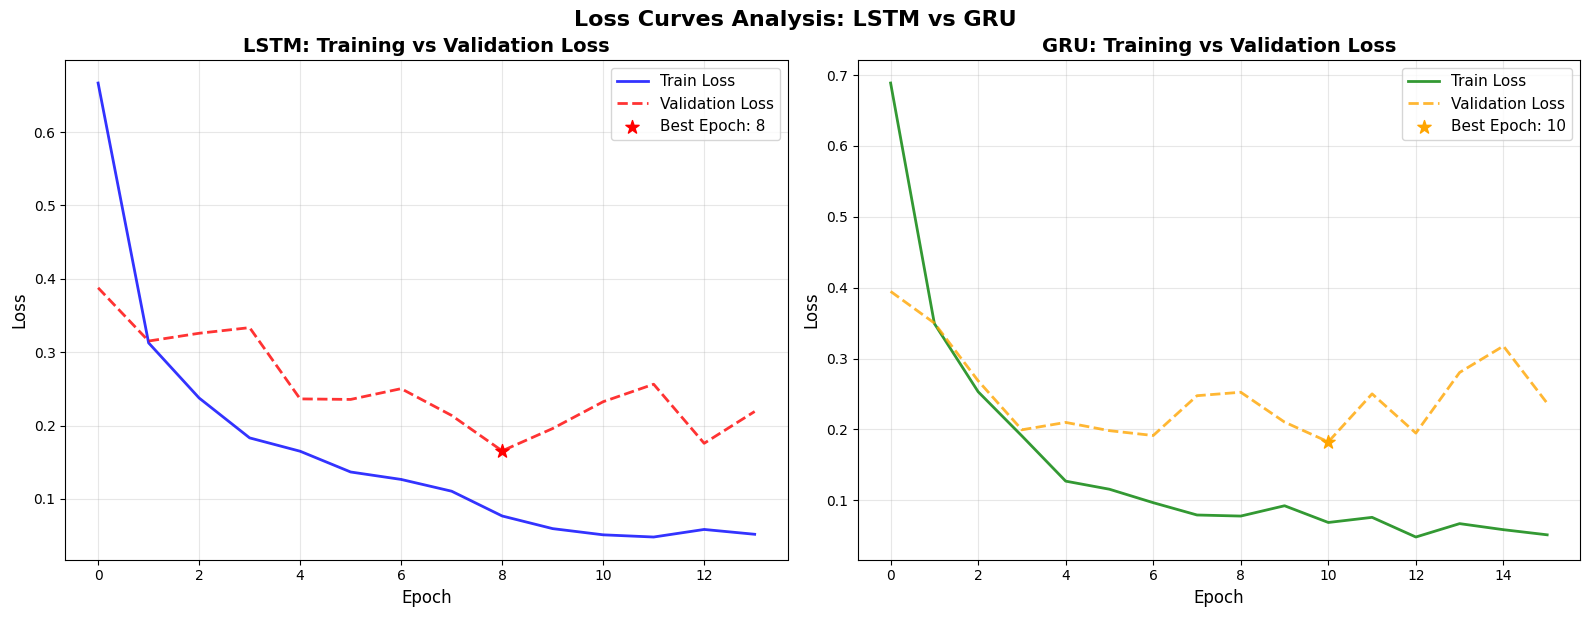

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# LSTM Train vs Validation Loss
axes[0].plot(lstm_history.history['loss'], label='Train Loss',
                color='blue', linewidth=2, alpha=0.8)
axes[0].plot(lstm_history.history['val_loss'], label='Validation Loss',
                color='red', linewidth=2, alpha=0.8, linestyle='--')
axes[0].set_title('LSTM: Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

best_epoch_lstm = np.argmin(lstm_history.history['val_loss'])
best_val_loss_lstm = np.min(lstm_history.history['val_loss'])
axes[0].scatter([best_epoch_lstm], [best_val_loss_lstm],
                   color='red', s=100, zorder=5, marker='*',
                   label=f'Best Epoch: {best_epoch_lstm}')
axes[0].legend(fontsize=11)

# GRU Train vs Validation Loss
axes[1].plot(gru_history.history['loss'], label='Train Loss',
                color='green', linewidth=2, alpha=0.8)
axes[1].plot(gru_history.history['val_loss'], label='Validation Loss',
                color='orange', linewidth=2, alpha=0.8, linestyle='--')
axes[1].set_title('GRU: Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

best_epoch_gru = np.argmin(gru_history.history['val_loss'])
best_val_loss_gru = np.min(gru_history.history['val_loss'])
axes[1].scatter([best_epoch_gru], [best_val_loss_gru],
                   color='orange', s=100, zorder=5, marker='*',
                   label=f'Best Epoch: {best_epoch_gru}')
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.suptitle('Loss Curves Analysis: LSTM vs GRU', fontsize=16, fontweight='bold', y=1.02)
plt.show()


# **confusion matrix**

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


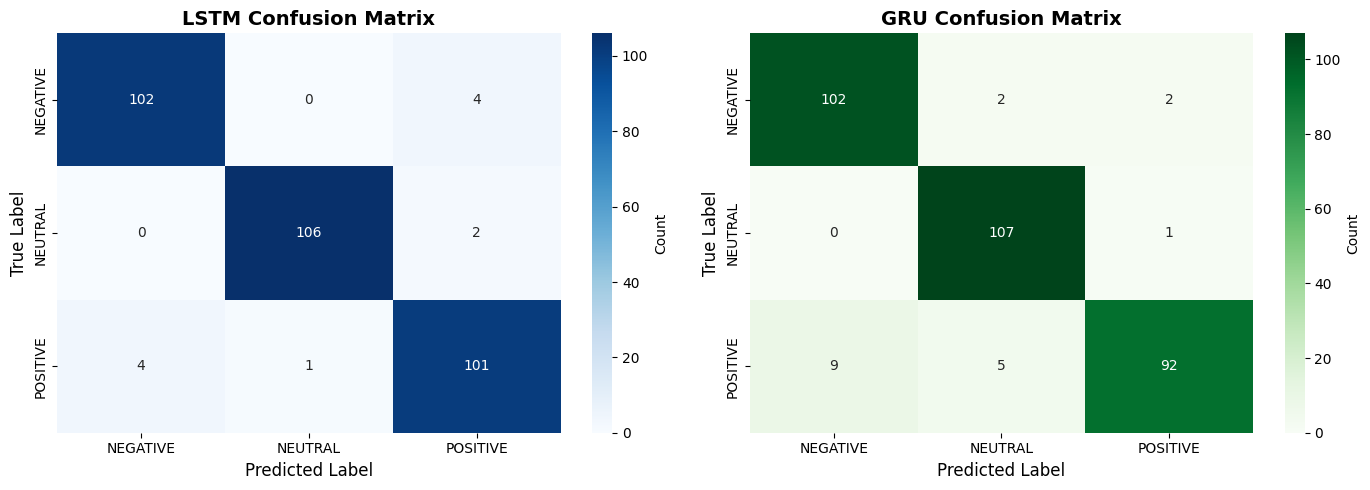

In [ ]:
from sklearn.metrics import confusion_matrix

lstm_predictions = lstm_model.predict(X_test)
gru_predictions = gru_model.predict(X_test)

lstm_pred_classes = np.argmax(lstm_predictions, axis=1)
gru_pred_classes = np.argmax(gru_predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)


cm_lstm = confusion_matrix(true_classes, lstm_pred_classes)
cm_gru = confusion_matrix(true_classes, gru_pred_classes)


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LSTM confusion matrix
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Count'})
axes[0].set_title('LSTM Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# GRU confusion matrix
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=le.classes_, yticklabels=le.classes_,
            cbar_kws={'label': 'Count'})
axes[1].set_title('GRU Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()